<a href="https://colab.research.google.com/github/routb68/hdlc/blob/main/fastText200D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model loading and Data loading

In [ ]:
import numpy as np
import pickle
from gensim.models import FastText
import matplotlib.pyplot as plt
# model = FastText.load('/content/drive/MyDrive/Fairness in machine learning/word embedding Models /Hindi/50/fasttext/hi-d50-m2-fasttext.model')
# fasttext_transform = model.wv

#data loading and attaching religion
with open('/content/drive/MyDrive/Fairness in machine learning/HLDC   LDA preWork/df.pkl', 'rb') as file:
    df = pickle.load(file)

data, data_label = df['sentence_cleaned_split'], df['label']

muslim = {"अब्दुल", "अहमद", "आरिफ", "खां", "खालिद", "नदीम", "मुस्लिम", "मोहम्मद", "रिजवान", "सलीम" }
hindu = {"अमरजीत", "आर्य", "आशीष", "ओमकार", "किशोर", "कुलदीप", "जयराम", "धीरेन्द्र", "नितिन", "मुलायम", "राजपूत", "रामानन्द", "विजयपाल", "विमलेश", "श्रीराम"}


gt_data,gt_label,gt_reli = [],[],[]

num_hindu, num_muslim = 0,0
for i in range(10000):
  for x in data[i]:
     for y in muslim:
      if(x==y):
        gt_data.append(data[i]);
        gt_label.append(data_label[i])
        gt_reli.append(1)
        num_muslim += 1
        break;


     for y in hindu:
      if(x==y):
        gt_data.append(data[i]);
        gt_label.append(data_label[i])
        gt_reli.append(2)
        num_hindu += 1
        break;


org_gt_data,org_gt_label,org_gt_reli =gt_data,gt_label,gt_reli

gt_data,gt_label,gt_reli = [], [], []

cnt1, cnt2 = 0, 0

for i in range(len(org_gt_data)):
  if(org_gt_reli[i]==1 and cnt1<1010):
    gt_data.append(org_gt_data[i])
    gt_label.append(org_gt_label[i])
    gt_reli.append(org_gt_reli[i])
    cnt1+=1;
  elif (org_gt_reli[i]==2 and cnt2<1010):
    gt_data.append(org_gt_data[i])
    gt_label.append(org_gt_label[i])
    gt_reli.append(org_gt_reli[i])
    cnt2+=1;

print(cnt1)
print(cnt2)
print(len(gt_data))
len(org_gt_data)

1010
1010
2020


2779

In [ ]:
len(org_gt_data)

2779

#PCA function and w2v function

vector extrima min transformation

In [ ]:
def w2v_min_transform(gt_data,fasttext_transform,num_data_points,dimension):# gt_data = ground truth data,
                                                           #fastText_transform = model.word2vec,
                                                           #dimension = dim of w2vec
                                                           #num_data_points = 2020 for our case

  data_xx = []
  for i in range(num_data_points):
    temp = []
    for j in gt_data[i]:
      temp.append(fasttext_transform[j])
    a = np.zeros((1,dimension))
    for k in range(dimension):    #setting a bigger value to get min val in latter stage
      a[0][k] = 1e9
    for k in range(dimension):
      for k1 in range(len(temp)):
        c = 1.0 * (temp[k1][k])
        if(abs(a[0][k])) > abs(c):
          a[0][k] = c
    data_xx.append(a)
  pca_vec = np.zeros((num_data_points,dimension))
  for i in range(num_data_points):
    for j in range(dimension):
      pca_vec[i][j] = data_xx[i][0][j]
  return pca_vec

vector extrima max transformation

In [ ]:
def w2v_max_transform(gt_data,fasttext_transform,num_data_points,dimension):# gt_data = ground truth data,
                                                           #fastText_transform = model.word2vec,
                                                           #dimension = dim of w2vec
                                                           #num_data_points = 2020 for our case

  data_xx = []
  for i in range(num_data_points):
    temp = []
    for j in gt_data[i]:
      temp.append(fasttext_transform[j])
    a = np.zeros((1,dimension))

    for k in range(dimension):
      for k1 in range(len(temp)):
        c = 1.0 * (temp[k1][k])
        if(abs(a[0][k])) < abs(c):
          a[0][k] = c
    data_xx.append(a)
  pca_vec = np.zeros((num_data_points,dimension))
  for i in range(num_data_points):
    for j in range(dimension):
      pca_vec[i][j] = data_xx[i][0][j]
  return pca_vec

reconstruction error function

In [ ]:
def re_error(n,pca_data,dimension,num_data):# n = number of principal component, x_data = pca_data,
                                   # dimension = fast text transformesd dimension
  total_cost, hindu_cost, muslim_cost = 0,0,0

  #mean calculation
  mean_data = np.mean(pca_data, axis=0)

  for i in range(num_data):
    pca_data[i] -= mean_data

  #pca calculation
  cov_mat = np.cov(np.transpose(pca_data))
  eig_vals, eig_vecs = np.linalg.eig(cov_mat)
  idx = eig_vals.argsort()[::-1]
  eig_vals = eig_vals[idx]
  eig_vecs = eig_vecs[:,idx]

  # reconstruction error calculation
  # x = cost, z = accumulative cost wrt dimension
  x=0
  for i in range(num_data):
    x = 0
    z = np.zeros((1,dimension))
    for j in range(n):
      z += (((np.dot(np.transpose(pca_data[i]),eig_vecs[j]))) * eig_vecs[j])

    x += (np.linalg.norm (z - pca_data[i]))

    total_cost += x
    if gt_reli[i]==1:
      muslim_cost += x
    else :
      hindu_cost += x
  # print(total_cost)

  total_cost /= num_data
  hindu_cost /= (num_data/2)
  muslim_cost /= (num_data/2)

  return total_cost, hindu_cost, muslim_cost

In [ ]:
model200 = FastText.load('/content/drive/MyDrive/Fairness in machine learning/word embedding Models /Hindi/200/fasttext/hi-d200-m2-fasttext.model')
fasttext_transform200 = model200.wv

#PCA reconstruction error for 200-dim fastText min vector extrima

In [ ]:
pca_data = w2v_min_transform(gt_data,fasttext_transform200,2020,200)

In [ ]:
print(pca_data.shape)

(2020, 200)


In [ ]:
pca_data[0]

array([-1.25453970e-03, -5.93323610e-04, -3.75612930e-04,  2.14896481e-05,
       -1.03734352e-03, -1.00828949e-02,  8.90868076e-04,  1.12090791e-04,
        7.63496035e-04,  8.19878944e-04,  4.46363643e-04, -9.84569429e-04,
       -1.98453665e-04,  4.58002090e-04,  5.58836095e-04,  1.90374360e-03,
        5.54234209e-03,  8.27745971e-05, -1.68463588e-03,  9.96147632e-04,
       -7.43356592e-04,  5.31740393e-03,  1.90385181e-04, -9.16523742e-04,
       -1.29268388e-03, -5.55543113e-04, -1.22574752e-03,  8.81488813e-05,
       -5.57212275e-04,  2.47997302e-03, -1.43088505e-03,  1.78052054e-03,
       -1.43449171e-03,  1.15280354e-03,  6.62429072e-03, -5.84957364e-04,
        2.12452622e-04,  1.47009687e-03,  3.07246833e-03, -3.00614047e-04,
       -3.21237603e-03,  5.73795754e-04,  8.30038116e-05,  1.53345719e-03,
       -2.52553400e-05,  6.48250571e-03, -4.29749489e-04, -2.16695806e-03,
       -1.81514805e-03,  3.97513322e-05,  3.21940752e-03,  3.05788097e-04,
        1.42860413e-03, -

In [ ]:
x1 = []
for i in range(1,200):
  x1.append(i)

In [ ]:
reconstruction_error_total, reconstruction_error_hindu, reconstruction_error_muslim = [], [], []

for i in range(1,200):
  re_t,re_h,re_m = re_error(i,pca_data,200,2020)
  reconstruction_error_total.append(re_t)
  reconstruction_error_hindu.append(re_h)
  reconstruction_error_muslim.append(re_m)
  # print()

print(reconstruction_error_muslim)
print(reconstruction_error_total)
print(reconstruction_error_hindu)

[0.04326225160954358, 0.04311667312440547, 0.04303979945060003, 0.04294284383764673, 0.04253075453179364, 0.04247398943135435, 0.04240591914184802, 0.042313989185792066, 0.04215697447320457, 0.04209164713320393, 0.042000280182665536, 0.041837506724915124, 0.041720557105145675, 0.04166069680764048, 0.04153083604922961, 0.04136246686019635, 0.04127827499783617, 0.041167638179262174, 0.04105005751025152, 0.040976021793218666, 0.04085752304474449, 0.040677187756578706, 0.040737829784778426, 0.04049174025105702, 0.0404568897986394, 0.04035638994499962, 0.04013686439708622, 0.0400707750206673, 0.04007952465746755, 0.039912019587819, 0.039689026814582334, 0.03962974009676275, 0.039509007363489994, 0.039413867279448546, 0.039379029263772285, 0.03918888261664026, 0.039100504921455025, 0.03892644852441823, 0.03884130807534043, 0.03881197174372728, 0.03862155768684822, 0.038523060636167096, 0.038314318370870966, 0.03821790775336161, 0.038115774106164076, 0.037933574951496504, 0.03794178064508496,

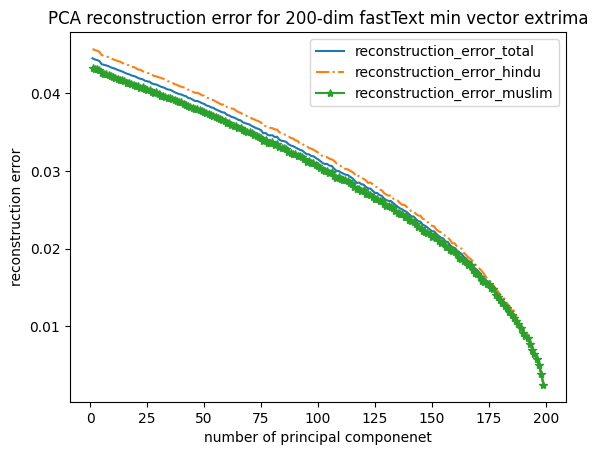

In [ ]:
plt.plot(x1, reconstruction_error_total,label ='reconstruction_error_total')
plt.plot(x1, reconstruction_error_hindu, '-.',label ='reconstruction_error_hindu')
plt.plot(x1,reconstruction_error_muslim,'-*',label ='reconstruction_error_muslim')

plt.xlabel("number of principal componenet")
plt.ylabel("reconstruction error")
plt.legend()
plt.title('PCA reconstruction error for 200-dim fastText min vector extrima')
plt.savefig("PCA reconstruction error for 200-dim fastText min vector extrima.png")
plt.show()

#PCA and Reconstruction error for 50-dim fastText max vec extrima

In [ ]:
pca_data = w2v_max_transform(gt_data,fasttext_transform200,2020,200)
print(pca_data.shape)

(2020, 200)


In [ ]:
pca_data[0]

array([ 1.2062453 ,  0.7656098 ,  0.92758667,  0.94335818, -0.77523869,
        0.9940353 ,  0.91191047, -0.88610941, -0.6907084 , -1.05993342,
       -0.99470747,  0.75279242,  0.99297804,  0.70054001, -1.15885961,
        0.57876796,  0.64647704,  0.68865782,  0.83906633,  0.96244365,
        0.8672927 , -0.76142168, -0.7330963 ,  0.74872953,  1.0030266 ,
       -1.0377084 , -0.91498649, -1.0168848 ,  0.80591792, -0.85861701,
       -1.38573921,  0.92630285, -0.89504039,  0.8256979 , -0.83808726,
       -0.74892402, -0.80268925,  0.89213961, -0.90886718, -0.85320944,
        0.65274757, -1.37230742,  0.88167202,  0.86543363,  0.61128408,
        0.70177925, -0.7498526 , -0.79729575,  0.74328667, -0.69400507,
       -0.99142385,  0.65052766,  0.90229106,  0.87056684, -0.72902715,
        0.81113541,  0.81253409, -0.8088389 ,  0.81646639,  1.10034001,
        0.72259104,  0.75624192,  0.76083666,  0.77637172, -0.74367738,
       -1.31501758,  0.6369586 ,  0.57722294, -0.90747017,  0.69

In [ ]:
reconstruction_error_total, reconstruction_error_hindu, reconstruction_error_muslim = [], [], []

for i in range(1,200):
  re_t,re_h,re_m = re_error(i,pca_data,200,2020)
  reconstruction_error_total.append(re_t)
  reconstruction_error_hindu.append(re_h)
  reconstruction_error_muslim.append(re_m)
  # print()

print(reconstruction_error_muslim)
print(reconstruction_error_total)
print(reconstruction_error_hindu)

[7.499557387922501, 7.478244009617928, 7.451784277286923, 7.444691633659394, 7.436369549719586, 7.410175279253412, 7.386017506842948, 7.36705485345419, 7.36778832298629, 7.339505313241371, 7.32893914505173, 7.312326851515668, 7.29495795879964, 7.258249187602284, 7.263895963608513, 7.24681200544394, 7.212094242115005, 7.209480078406646, 7.190952441527891, 7.151912435057514, 7.146096916753898, 7.143342942559164, 7.097193570177328, 7.090810412603709, 7.0749328920735035, 7.048057433199725, 7.037862364227905, 6.977697496333155, 6.982880940674875, 6.916576695065868, 6.890616101169378, 6.9043520023617715, 6.866360947788374, 6.849421849039019, 6.839453528523823, 6.823856316273341, 6.816555461427132, 6.785838149057216, 6.7471139827279485, 6.70878184368302, 6.736287481822719, 6.6937136776543475, 6.707522374015796, 6.669623368712143, 6.640722772192021, 6.595123940547874, 6.55435789286889, 6.574397125473067, 6.500001134728231, 6.524758410779115, 6.5102321536659655, 6.483508632775676, 6.45267957482

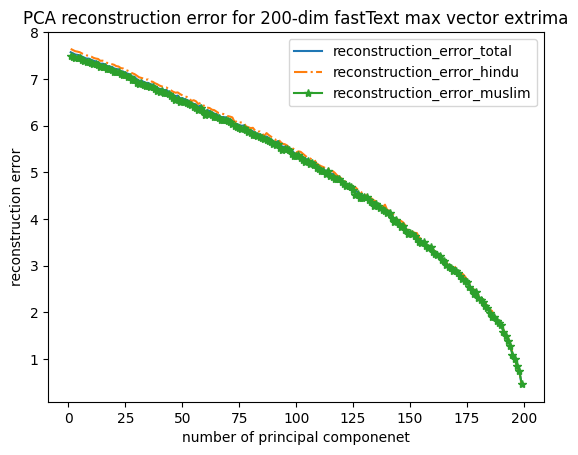

In [ ]:
plt.plot(x1, reconstruction_error_total,label ='reconstruction_error_total')
plt.plot(x1, reconstruction_error_hindu, '-.',label ='reconstruction_error_hindu')
plt.plot(x1, reconstruction_error_muslim,'-*',label ='reconstruction_error_muslim')

plt.xlabel("number of principal componenet")
plt.ylabel("reconstruction error")
plt.legend()
plt.title('PCA reconstruction error for 200-dim fastText max vector extrima')
plt.savefig("PCA reconstruction error for 200-dim fastText max vector extrima.png")
plt.show()